# Elastic-net regularized Cox proportional hazards with Keras
Author: George H. Chen (georgechen [at symbol] cmu.edu)

This notebook shows how to implement a neural net version of elastic-net regularized Cox proportional hazards using Keras. It uses a survival analysis dataset from the Lifelines library. It also runs standard Cox proportional hazards model fitting without regularization (using Lifelines), and elastic-net regularized Cox proportional hazards (using glmnet) as reference implementations.

Note that the neural net version of elastic-net regularized Cox proportional hazards uses Breslow's method for handling ties (in observed times), meaning that it does not treat ties in any special way (unlike Efron's method, which is used by the Lifelines library).

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)

### Load in a simple dataset to try survival regression with

In [25]:
from lifelines.datasets import load_regression_dataset
regression_dataset = load_regression_dataset()

regression_dataset.head()

regression_dataset_nparray = np.array(regression_dataset)
x = regression_dataset_nparray[:, :3]
y = regression_dataset_nparray[:, 3:]
noncensored = y[:, 1].astype(np.bool)

### Lifelines code for survival regression using Cox proportional hazards (not regularized!)

n=200, number of events=189

       coef  exp(coef)  se(coef)      z      p  lower 0.95  upper 0.95    
var1 0.2214     1.2478    0.0743 2.9807 0.0029      0.0758      0.3669  **
var2 0.0508     1.0521    0.0829 0.6129 0.5400     -0.1117      0.2133    
var3 0.2187     1.2444    0.0758 2.8851 0.0039      0.0701      0.3672  **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.580
Likelihood ratio test = 15.508 on 3 df, p=0.00143
RMSE: 3.4214154270899986
MAE: 2.671711703703704


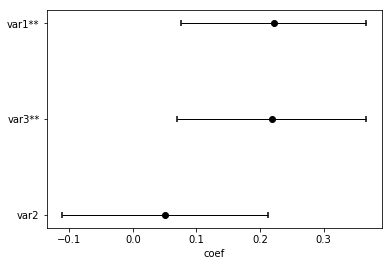

In [10]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(regression_dataset, 'T', event_col='E')
cph.print_summary()
cph.plot()

# it's also possible to extract beta coefficients using the following:
# cph.hazards_.loc['coef'].values

# compute median survival times
cph_median_survival_times = np.array(cph.predict_median(regression_dataset)).flatten()
print('RMSE:',
      np.sqrt(np.mean((cph_median_survival_times[noncensored]
                       - y[noncensored, 0])**2)))
print('MAE:',
      np.mean(np.abs(cph_median_survival_times[noncensored]
                     - y[noncensored, 0])))

### `glmnet` code for elastic-net regularized Cox proportional hazards

In [11]:
import glmnet_python
from glmnet import glmnet
from glmnetCoef import glmnetCoef

lmbda = 0.1
alpha = 1.
fit = glmnet(x=x.copy(), y=y.copy(), family='cox', alpha=alpha, standardize=True, intr=False)
beta = glmnetCoef(fit, s=np.array([lmbda]))
print('Beta:', beta.flatten())

Beta: [0.10391 0.      0.09968]


### Keras code for Cox proportional hazards survival layer

In [26]:
# note: to have the code logic more closely resemble what Lifelines' Cox
# proportional hazards model does, we also first standardize the feature vectors
# before fitting (note that Lifelines' Cox proportional hazards model fitter
# undoes the standard deviation scaling right after fitting, but it does *not*
# undo the removal of the mean)

from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
x_standardized = standard_scaler.fit_transform(x)

In [13]:
import keras.backend as K

Using TensorFlow backend.


Helpful links:
- Writing custom Keras loss functions: https://stackoverflow.com/questions/45961428/make-a-custom-loss-function-in-keras

In [14]:
def coxph_partial_log_likelihood_batch(y_true, y_pred, batch_size):
    # y_pred in this context consists of each feature vector dotted with beta, with a 1 padded
    y_observed_times = y_true[:, 0]
    y_event_indicators = y_true[:, 1]
    
    R_batch = K.cast(K.greater_equal(K.repeat_elements(K.expand_dims(y_observed_times, axis=0), batch_size, 0),
                                     K.repeat_elements(K.expand_dims(y_observed_times, axis=-1), batch_size, -1)),
                     'float32')
    
    x_transpose_beta = y_pred[:, 0]
    return -K.mean((x_transpose_beta
                    - K.log(K.flatten(K.dot(R_batch,
                                            K.expand_dims(K.exp(x_transpose_beta), axis=-1)))))
                   * y_event_indicators)

batch_size = len(x)  # yes, the code works even when batch size is not the full dataset
coxph_partial_log_likelihood = lambda y_true, y_pred: coxph_partial_log_likelihood_batch(y_true, y_pred, batch_size)


Note that for elastic-net regularization with the Cox proportional hazards model, the standard approach is to use the following regularizer:

$$\lambda \Big(\alpha \|\beta\|_1 + \frac{1}{2}(1-\alpha)\|\beta\|_2^2\Big)$$

In particular, the $\ell_1$ regularization has coefficient $\lambda \alpha$. The $\ell_2$ regularization has coefficient $\lambda (1-\alpha)/2$.

In [35]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers

# warning: depending on the values for lmbda and alpha, a different optimizer
# may be needed to get convergence (inspect training loss over epochs)
lmbda = 0.1
alpha = 1.

l1_weight = lmbda * alpha
l2_weight = lmbda * (1-alpha) / 2.

coxph_neural = models.Sequential()
coxph_neural.add(layers.Dense(2, activation=None, input_shape=(x.shape[1],), use_bias=False))
coxph_neural.add(layers.Dense(1, activation=None, input_shape=(2,),
                              kernel_regularizer=regularizers.L1L2(l1_weight,
                                                                   l2_weight),
                              use_bias=False))
coxph_neural.add(layers.Lambda(lambda x: K.concatenate([x, K.ones_like(x)],
                                                       axis=-1)))
coxph_neural.summary()

coxph_neural.compile(optimizer='Adam', loss=coxph_partial_log_likelihood)

coxph_neural.fit(x_standardized, y, epochs=2000, batch_size=batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
_________________________________________________________________
lambda_3 (Lambda)            (None, 2)                 0         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
200/200 [==============================] - 0s 2ms/step - loss: 4.6643
Epoch 2/2000
200/200 [==============================] - 0s 10us/step - loss: 4.6613
Epoch 3/2000
200/200 [==============================] - 0s 11us/step - loss: 4.6587
Epoch 4/2000
200/200 [==============================] - 0s 9us/step - loss: 4.6557
Epoch 5/2000
200/200 [==============================] - 0s 16us/step - loss: 4

200/200 [==============================] - 0s 12us/step - loss: 4.4816
Epoch 90/2000
200/200 [==============================] - 0s 16us/step - loss: 4.4802
Epoch 91/2000
200/200 [==============================] - 0s 11us/step - loss: 4.4789
Epoch 92/2000
200/200 [==============================] - 0s 12us/step - loss: 4.4775
Epoch 93/2000
200/200 [==============================] - 0s 13us/step - loss: 4.4761
Epoch 94/2000
200/200 [==============================] - 0s 23us/step - loss: 4.4748
Epoch 95/2000
200/200 [==============================] - 0s 19us/step - loss: 4.4735
Epoch 96/2000
200/200 [==============================] - 0s 11us/step - loss: 4.4722
Epoch 97/2000
200/200 [==============================] - 0s 11us/step - loss: 4.4710
Epoch 98/2000
200/200 [==============================] - 0s 14us/step - loss: 4.4697
Epoch 99/2000
200/200 [==============================] - 0s 15us/step - loss: 4.4685
Epoch 100/2000
200/200 [==============================] - 0s 17us/step - loss: 

Epoch 185/2000
200/200 [==============================] - 0s 14us/step - loss: 4.3770
Epoch 186/2000
200/200 [==============================] - 0s 15us/step - loss: 4.3761
Epoch 187/2000
200/200 [==============================] - 0s 11us/step - loss: 4.3752
Epoch 188/2000
200/200 [==============================] - 0s 12us/step - loss: 4.3743
Epoch 189/2000
200/200 [==============================] - 0s 13us/step - loss: 4.3735
Epoch 190/2000
200/200 [==============================] - 0s 12us/step - loss: 4.3726
Epoch 191/2000
200/200 [==============================] - 0s 17us/step - loss: 4.3717
Epoch 192/2000
200/200 [==============================] - 0s 22us/step - loss: 4.3709
Epoch 193/2000
200/200 [==============================] - 0s 16us/step - loss: 4.3700
Epoch 194/2000
200/200 [==============================] - 0s 23us/step - loss: 4.3691
Epoch 195/2000
200/200 [==============================] - 0s 14us/step - loss: 4.3683
Epoch 196/2000
200/200 [==============================

Epoch 281/2000
200/200 [==============================] - 0s 12us/step - loss: 4.3047
Epoch 282/2000
200/200 [==============================] - 0s 13us/step - loss: 4.3041
Epoch 283/2000
200/200 [==============================] - 0s 12us/step - loss: 4.3035
Epoch 284/2000
200/200 [==============================] - 0s 12us/step - loss: 4.3028
Epoch 285/2000
200/200 [==============================] - 0s 18us/step - loss: 4.3022
Epoch 286/2000
200/200 [==============================] - 0s 13us/step - loss: 4.3016
Epoch 287/2000
200/200 [==============================] - 0s 12us/step - loss: 4.3009
Epoch 288/2000
200/200 [==============================] - 0s 10us/step - loss: 4.3003
Epoch 289/2000
200/200 [==============================] - 0s 11us/step - loss: 4.2997
Epoch 290/2000
200/200 [==============================] - 0s 18us/step - loss: 4.2991
Epoch 291/2000
200/200 [==============================] - 0s 13us/step - loss: 4.2984
Epoch 292/2000
200/200 [==============================

Epoch 377/2000
200/200 [==============================] - 0s 13us/step - loss: 4.2505
Epoch 378/2000
200/200 [==============================] - 0s 18us/step - loss: 4.2500
Epoch 379/2000
200/200 [==============================] - 0s 16us/step - loss: 4.2495
Epoch 380/2000
200/200 [==============================] - 0s 15us/step - loss: 4.2490
Epoch 381/2000
200/200 [==============================] - 0s 15us/step - loss: 4.2485
Epoch 382/2000
200/200 [==============================] - 0s 14us/step - loss: 4.2480
Epoch 383/2000
200/200 [==============================] - 0s 14us/step - loss: 4.2475
Epoch 384/2000
200/200 [==============================] - 0s 11us/step - loss: 4.2470
Epoch 385/2000
200/200 [==============================] - 0s 10us/step - loss: 4.2465
Epoch 386/2000
200/200 [==============================] - 0s 9us/step - loss: 4.2460
Epoch 387/2000
200/200 [==============================] - 0s 15us/step - loss: 4.2455
Epoch 388/2000
200/200 [==============================]

Epoch 473/2000
200/200 [==============================] - 0s 17us/step - loss: 4.2040
Epoch 474/2000
200/200 [==============================] - 0s 16us/step - loss: 4.2035
Epoch 475/2000
200/200 [==============================] - 0s 13us/step - loss: 4.2031
Epoch 476/2000
200/200 [==============================] - 0s 15us/step - loss: 4.2026
Epoch 477/2000
200/200 [==============================] - 0s 10us/step - loss: 4.2021
Epoch 478/2000
200/200 [==============================] - 0s 13us/step - loss: 4.2016
Epoch 479/2000
200/200 [==============================] - 0s 13us/step - loss: 4.2012
Epoch 480/2000
200/200 [==============================] - 0s 11us/step - loss: 4.2007
Epoch 481/2000
200/200 [==============================] - 0s 10us/step - loss: 4.2002
Epoch 482/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1998
Epoch 483/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1993
Epoch 484/2000
200/200 [==============================

Epoch 569/2000
200/200 [==============================] - 0s 14us/step - loss: 4.1603
Epoch 570/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1599
Epoch 571/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1595
Epoch 572/2000
200/200 [==============================] - 0s 20us/step - loss: 4.1590
Epoch 573/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1586
Epoch 574/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1582
Epoch 575/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1578
Epoch 576/2000
200/200 [==============================] - 0s 14us/step - loss: 4.1574
Epoch 577/2000
200/200 [==============================] - 0s 23us/step - loss: 4.1569
Epoch 578/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1565
Epoch 579/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1561
Epoch 580/2000
200/200 [==============================

Epoch 665/2000
200/200 [==============================] - 0s 21us/step - loss: 4.1262
Epoch 666/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1260
Epoch 667/2000
200/200 [==============================] - 0s 17us/step - loss: 4.1257
Epoch 668/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1254
Epoch 669/2000
200/200 [==============================] - 0s 22us/step - loss: 4.1252
Epoch 670/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1249
Epoch 671/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1247
Epoch 672/2000
200/200 [==============================] - 0s 18us/step - loss: 4.1244
Epoch 673/2000
200/200 [==============================] - 0s 21us/step - loss: 4.1242
Epoch 674/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1239
Epoch 675/2000
200/200 [==============================] - 0s 15us/step - loss: 4.1237
Epoch 676/2000
200/200 [==============================

Epoch 761/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1098
Epoch 762/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1097
Epoch 763/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1096
Epoch 764/2000
200/200 [==============================] - 0s 16us/step - loss: 4.1095
Epoch 765/2000
200/200 [==============================] - 0s 18us/step - loss: 4.1094
Epoch 766/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1093
Epoch 767/2000
200/200 [==============================] - 0s 16us/step - loss: 4.1092
Epoch 768/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1091
Epoch 769/2000
200/200 [==============================] - 0s 16us/step - loss: 4.1090
Epoch 770/2000
200/200 [==============================] - 0s 10us/step - loss: 4.1089
Epoch 771/2000
200/200 [==============================] - 0s 18us/step - loss: 4.1088
Epoch 772/2000
200/200 [==============================

Epoch 857/2000
200/200 [==============================] - 0s 16us/step - loss: 4.1029
Epoch 858/2000
200/200 [==============================] - 0s 13us/step - loss: 4.1028
Epoch 859/2000
200/200 [==============================] - 0s 14us/step - loss: 4.1028
Epoch 860/2000
200/200 [==============================] - 0s 12us/step - loss: 4.1027
Epoch 861/2000
200/200 [==============================] - 0s 20us/step - loss: 4.1026
Epoch 862/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1026
Epoch 863/2000
200/200 [==============================] - 0s 10us/step - loss: 4.1025
Epoch 864/2000
200/200 [==============================] - 0s 14us/step - loss: 4.1025
Epoch 865/2000
200/200 [==============================] - 0s 17us/step - loss: 4.1024
Epoch 866/2000
200/200 [==============================] - 0s 14us/step - loss: 4.1024
Epoch 867/2000
200/200 [==============================] - 0s 11us/step - loss: 4.1023
Epoch 868/2000
200/200 [==============================

Epoch 953/2000
200/200 [==============================] - 0s 28us/step - loss: 4.0977
Epoch 954/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0976
Epoch 955/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0975
Epoch 956/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0975
Epoch 957/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0974
Epoch 958/2000
200/200 [==============================] - 0s 19us/step - loss: 4.0974
Epoch 959/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0973
Epoch 960/2000
200/200 [==============================] - 0s 25us/step - loss: 4.0973
Epoch 961/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0972
Epoch 962/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0972
Epoch 963/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0971
Epoch 964/2000
200/200 [==============================

Epoch 1048/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0927
Epoch 1049/2000
200/200 [==============================] - 0s 19us/step - loss: 4.0926
Epoch 1050/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0926
Epoch 1051/2000
200/200 [==============================] - 0s 21us/step - loss: 4.0925
Epoch 1052/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0925
Epoch 1053/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0924
Epoch 1054/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0924
Epoch 1055/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0923
Epoch 1056/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0923
Epoch 1057/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0922
Epoch 1058/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0922
Epoch 1059/2000
200/200 [==================

Epoch 1143/2000
200/200 [==============================] - 0s 9us/step - loss: 4.0878
Epoch 1144/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0877
Epoch 1145/2000
200/200 [==============================] - 0s 9us/step - loss: 4.0877
Epoch 1146/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0876
Epoch 1147/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0876
Epoch 1148/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0875
Epoch 1149/2000
200/200 [==============================] - 0s 23us/step - loss: 4.0875
Epoch 1150/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0874
Epoch 1151/2000
200/200 [==============================] - 0s 19us/step - loss: 4.0874
Epoch 1152/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0873
Epoch 1153/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0873
Epoch 1154/2000
200/200 [====================

Epoch 1238/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0829
Epoch 1239/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0829
Epoch 1240/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0828
Epoch 1241/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0828
Epoch 1242/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0827
Epoch 1243/2000
200/200 [==============================] - 0s 21us/step - loss: 4.0827
Epoch 1244/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0826
Epoch 1245/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0826
Epoch 1246/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0825
Epoch 1247/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0825
Epoch 1248/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0824
Epoch 1249/2000
200/200 [==================

200/200 [==============================] - 0s 14us/step - loss: 4.0782
Epoch 1333/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0781
Epoch 1334/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0781
Epoch 1335/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0780
Epoch 1336/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0780
Epoch 1337/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0779
Epoch 1338/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0779
Epoch 1339/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0778
Epoch 1340/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0778
Epoch 1341/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0777
Epoch 1342/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0777
Epoch 1343/2000
200/200 [==============================] - 

Epoch 1427/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0734
Epoch 1428/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0734
Epoch 1429/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0733
Epoch 1430/2000
200/200 [==============================] - 0s 9us/step - loss: 4.0733
Epoch 1431/2000
200/200 [==============================] - 0s 9us/step - loss: 4.0732
Epoch 1432/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0732
Epoch 1433/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0731
Epoch 1434/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0731
Epoch 1435/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0730
Epoch 1436/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0730
Epoch 1437/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0729
Epoch 1438/2000
200/200 [====================

Epoch 1522/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0688
Epoch 1523/2000
200/200 [==============================] - 0s 20us/step - loss: 4.0687
Epoch 1524/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0687
Epoch 1525/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0686
Epoch 1526/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0686
Epoch 1527/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0685
Epoch 1528/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0685
Epoch 1529/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0684
Epoch 1530/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0684
Epoch 1531/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0683
Epoch 1532/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0683
Epoch 1533/2000
200/200 [==================

Epoch 1617/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0642
Epoch 1618/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0642
Epoch 1619/2000
200/200 [==============================] - 0s 21us/step - loss: 4.0642
Epoch 1620/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0641
Epoch 1621/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0641
Epoch 1622/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0640
Epoch 1623/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0640
Epoch 1624/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0639
Epoch 1625/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0639
Epoch 1626/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0638
Epoch 1627/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0638
Epoch 1628/2000
200/200 [==================

Epoch 1712/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0599
Epoch 1713/2000
200/200 [==============================] - 0s 9us/step - loss: 4.0598
Epoch 1714/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0598
Epoch 1715/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0597
Epoch 1716/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0597
Epoch 1717/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0597
Epoch 1718/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0596
Epoch 1719/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0596
Epoch 1720/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0595
Epoch 1721/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0595
Epoch 1722/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0594
Epoch 1723/2000
200/200 [===================

Epoch 1807/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0557
Epoch 1808/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0557
Epoch 1809/2000
200/200 [==============================] - 0s 15us/step - loss: 4.0556
Epoch 1810/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0556
Epoch 1811/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0555
Epoch 1812/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0555
Epoch 1813/2000
200/200 [==============================] - 0s 23us/step - loss: 4.0554
Epoch 1814/2000
200/200 [==============================] - 0s 10us/step - loss: 4.0554
Epoch 1815/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0553
Epoch 1816/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0553
Epoch 1817/2000
200/200 [==============================] - 0s 23us/step - loss: 4.0553
Epoch 1818/2000
200/200 [==================

Epoch 1902/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0522
Epoch 1903/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0522
Epoch 1904/2000
200/200 [==============================] - 0s 14us/step - loss: 4.0522
Epoch 1905/2000
200/200 [==============================] - 0s 18us/step - loss: 4.0522
Epoch 1906/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0522
Epoch 1907/2000
200/200 [==============================] - 0s 11us/step - loss: 4.0522
Epoch 1908/2000
200/200 [==============================] - 0s 17us/step - loss: 4.0522
Epoch 1909/2000
200/200 [==============================] - 0s 23us/step - loss: 4.0522
Epoch 1910/2000
200/200 [==============================] - 0s 12us/step - loss: 4.0521
Epoch 1911/2000
200/200 [==============================] - 0s 23us/step - loss: 4.0521
Epoch 1912/2000
200/200 [==============================] - 0s 20us/step - loss: 4.0521
Epoch 1913/2000
200/200 [==================

200/200 [==============================] - 0s 11us/step - loss: 4.0515
Epoch 1997/2000
200/200 [==============================] - 0s 13us/step - loss: 4.0515
Epoch 1998/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0515
Epoch 1999/2000
200/200 [==============================] - 0s 16us/step - loss: 4.0515
Epoch 2000/2000
200/200 [==============================] - 0s 21us/step - loss: 4.0515


In [34]:
standard_scaler.scale_

array([0.939  , 0.9032 , 0.96267])

In [36]:
# just as with Lifelines' Cox proportional hazards model fitter, we undo the
# standard deviation scaling here (but not the mean removal)
weights = coxph_neural.get_weights()[1].flatten()
print(weights)
# coxph_neural_beta = weights[0].flatten() / standard_scaler.scale_
# print('Beta:', coxph_neural_beta)


[ 0.00005 -0.11082]


In [38]:
weights = coxph_neural.get_weights()[0]
weights

array([[ 0.2984 , -1.40081],
       [-0.13028, -0.35812],
       [-0.44905, -1.76197]], dtype=float32)

In [41]:
np.array(x_standardized).dot(weights)

array([[ -0.41245,  -0.81011],
       [  0.16956,   2.36783],
       [  0.24608,   1.32177],
       [  0.06583,   1.51861],
       [ -0.10545,  -2.56646],
       [  0.1919 ,   2.83436],
       [ -0.18959,   0.72449],
       [ -1.09395,  -4.41267],
       [  0.24293,   2.95567],
       [  0.30331,   1.36121],
       [  0.18393,   2.89664],
       [ -0.31666,  -1.27374],
       [  0.05904,   1.94696],
       [ -0.23747,   1.61263],
       [  0.34607,   0.52023],
       [ -0.34769,  -2.22572],
       [ -0.21132,   1.50591],
       [ -0.0096 ,   1.25214],
       [ -0.06836,  -0.10245],
       [  0.41111,   0.77915],
       [ -0.02404,   2.34085],
       [  0.12054,   2.50604],
       [  0.3534 ,   3.07567],
       [  0.03979,   2.38277],
       [  1.21028,  -5.62467],
       [  0.46623,  -0.10946],
       [ -0.02796,   2.2103 ],
       [ -0.09663,   1.87793],
       [ -1.7493 , -10.59959],
       [  0.33172,   1.95867],
       [ -0.72955,  -0.09833],
       [  0.10987,   2.72458],
       [

In [9]:
from collections import Counter
from scipy.special import logsumexp

def predict_median_survival_times(x_test, x_train, y_train, beta,
                                  average_to_get_median=True):
    # note: from inspecting Lifelines' code, Lifelines does not average to get
    # the median (e.g., find 2 nearest median points and take their average);
    # to get numerically nearly identical results, set parameter
    # `average_to_get_median` to False, plug in the beta learned by the
    # Lifelines' Cox proportional hazards, and be sure to subtract off the
    # training feature means from both `x_test` and `x_train`
    observed_times = y_train[:, 0]
    event_indicators = y_train[:, 1]
    
    event_counts = Counter()
    for t, r in zip(observed_times, event_indicators):
        event_counts[t] += int(r)
        
    sorted_unique_times = np.sort(list(event_counts.keys()))
    num_unique_times = len(sorted_unique_times)
    log_baseline_hazard = np.zeros(num_unique_times)
    for time_idx, t in enumerate(sorted_unique_times):
        logsumexp_args = []
        for subj_idx, observed_time in enumerate(observed_times):
            if observed_time >= t:
                logsumexp_args.append(np.inner(beta, x_train[subj_idx]))
        if event_counts[t] > 0:
            log_baseline_hazard[time_idx] \
                = np.log(event_counts[t]) - logsumexp(logsumexp_args)
        else:
            log_baseline_hazard[time_idx] \
                = -np.inf - logsumexp(logsumexp_args)

    # now we work with the test data
    num_test_subjects = len(x_test)
    median_survival_times = np.zeros(num_test_subjects)
    log_minus_log_half = np.log(-np.log(0.5))
    for subj_idx in range(num_test_subjects):
        log_hazard = log_baseline_hazard + np.inner(beta, x_test[subj_idx])
        log_cumulative_hazard = np.zeros(num_unique_times)
        for time_idx in range(num_unique_times):
            log_cumulative_hazard[time_idx] \
                = logsumexp(log_hazard[:time_idx + 1])

        t_inf = np.inf
        t_sup = 0.
        for time_idx, t in enumerate(sorted_unique_times):
            if log_minus_log_half <= log_cumulative_hazard[time_idx]:
                if t < t_inf:
                    t_inf = t
            if log_minus_log_half >= log_cumulative_hazard[time_idx]:
                if t > t_sup:
                    t_sup = t

        if average_to_get_median:
            median_survival_times[subj_idx] = 0.5 * (t_inf + t_sup)
        else:
            median_survival_times[subj_idx] = t_inf

    return median_survival_times

In [10]:
# compute median survival times using the learned neural Cox proportional
# hazards model's beta coefficients; note that at this point, beta already
# undoes the standard deviation scaling but still has mean removal, so to do the
# median survival time prediction, we apply it to the feature vectors with their
# means removed
mean_remover = StandardScaler()
x_zero_mean = mean_remover.fit_transform(x)

coxph_neural_median_survival_times \
    = predict_median_survival_times(x_zero_mean, x_zero_mean,
                                    y, coxph_neural_beta)
import lifelines
print('Concordance:',
      lifelines.utils.concordance_index(y[:, 0],
                                        coxph_neural_median_survival_times,
                                        y[:, 1]))
print('RMSE:',
      np.sqrt(np.mean((coxph_neural_median_survival_times[noncensored]
                       - y[noncensored, 0])**2)))
print('MAE:',
      np.mean(np.abs(coxph_neural_median_survival_times[noncensored]
                     - y[noncensored, 0])))

Concordance: 0.576213150714
RMSE: 3.44267400859
MAE: 2.69097285185
